<a href="https://colab.research.google.com/github/Spinkk/Implementing-ANNs-with-Tensorflow/blob/main/Tensorflow_MLP_Minseok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Preparation

In [13]:
def sigmoid(x):
  return 1 / (1 + np.exp(-1*x))


def sigmoid_prime(x):
  return sigmoid(x) * (1 - sigmoid(x))  # derivative can be defined by using the function itself


def error_func(t, y_hat):
  return (t - y_hat)**2


def error_func_prime(t,y_hat):
  return -(t - y_hat)


def accuracy_func(t, y_hat):
  if ((t==1) and (y_hat>=0.5)) or ((t==0) and (y_hat<0.5)):
    return True
  else:
    return False

# 2. Data set
Since our logical gates take only true or false, we can encode them with 1 and 0. The truth table of XOR gate looks as follows; 

In [26]:
# input at column 0,1 and output at 2
data_xor = np.array([[1,1,0],
              [1,0,1],
              [0,1,1],
              [0,0,0]])

# to check if perceptron works
data_or = np.array([[1,1,1],
                     [1,0,1],
                     [0,1,1],
                     [0,0,0]])

In [15]:
# code by Mathis for different logical operators
target_and = np.array([0,0,0,1])
target_or = np.array([0,1,1,1])
target_nand = np.array([1,1,1,0])
target_xor = np.array([0,1,1,0])
target_nor = np.array([1,0,0,0])

# 3. Perceptron

Do I need step activation function and Perceptron learning rule? In exercise sheet it's sigmoid based and in flipped room it's step func


In [36]:
class Perceptron:
  def __init__(self, input_units, learning_rate = 0.01):
    self.weights = np.random.randn(input_units + 1)  # random weight init incl. bias
    self.alpha = learning_rate

  def forward_step(self, inputs):
    self.inputs = np.insert(inputs, 0, 1)  # add bias dummy variable
    self.drive = np.dot(self.weights, self.inputs)  # inner product
    self.activation = sigmoid(self.drive)
        
  def update(self, delta):
    gradients = delta * self.inputs  # activation at one layer beforehand is input 
    self.weights = self.weights - self.alpha * gradients  # GD

Train OR

In [61]:
accuracies = []
p1 = Perceptron(2)

for _ in range(10000):
  index = np.random.choice([0,1,2,3])
  input = data_or[index, :-1] 
  label = data_or[index, -1]

  p1.forward_step(input)
  delta = error_func_prime(label, p1.activation) * sigmoid_prime(p1.drive)
  p1.update(delta)
  
  accuracies.append( # just append result of training examples without test
      accuracy_func(label, p1.activation))  

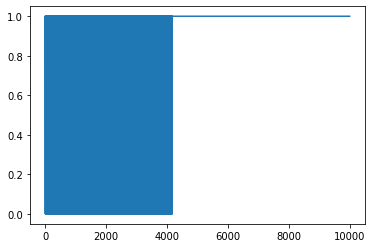

In [63]:
plt.plot(accuracies)

# 4. Multi-layer perceptron

In [102]:
class MLP:
  def __init__(self, input_dim, hidden_dim = [4,1]):
    total_dim = np.insert(hidden_dim, 0, input_dim)
    self.units = []  # nested list with each element as list of perceptrons at each layer
    for n,layer_dim in enumerate(total_dim[:-1]):  # don't enumerate the output layer
      layer = []
      for _ in range(total_dim[n+1]):  # num. of perceptron at layer n+1
        unit = Perceptron(layer_dim)  # num. of input for each perceptron coming from layer n
        layer.append(unit)
      self.units.append(layer)
    self.output = None

  def forward_step(self, inputs):
    assert len(inputs) == len(self.units[0][0].weights) - 1, 'input dimension should match the initalisation'
    activ = [inputs]  # TODO: no need to keep track of activation of all layers
    for layer in self.units:
      activ_layer = []
      for unit in layer:  # inefficient but no other way if we want to use class Perceptron()
        unit.forward_step(activ[-1])
        activ_layer.append(unit.activation) # drive for the next layer
      activ.append(activ_layer)
    self.output = activ_layer

  def backprop_step(self, label):
    error_signal = []  # 4+1 deltas in default cases
    # if readout layer
    layer_errors = []
    for i,unit in enumerate(self.units[-1]):
      delta = error_func_prime(label[i], unit.activation) * sigmoid_prime(unit.drive)
      layer_errors.append(delta) # keep for recursively computing deltas
      unit.update(delta) # update weight with computed delta
    error_signal.append(layer_errors)  # saved in reverse order (readout as first element)

    # else
    for l,layer in reversed(list(enumerate(self.units[:-1]))): # l also in descending orders
      layer_errors = []
      for i,unit in enumerate(layer):
        sums = 0
        for k,unit_higher in enumerate(self.units[l+1]): # deltas from l+1 layer
          sums += error_signal[-1][k] * unit_higher.weights[i+1]  # +1 due to bias
        delta = sums * sigmoid_prime(unit.drive)
        layer_errors.append(delta)
        unit.update(delta)
      error_signal.append(layer_errors)

# 5. Training
Interstingly, random training doesn't work for XOR.
For OR in perceptron, it worked. Reverbrating is important?


In [106]:
losses = []
accuracies = []
mlp_XOR = MLP(2)  # XOR is computed using two inputs

for _ in range(1000):
  # data_point_index = np.random.choice([0,1,2,3])  # 4 possible combinations to choose
  for data_point_index in range(4):
    input = data_xor[data_point_index,:-1]
    label = data_xor[data_point_index,-1]
  mlp_XOR.forward_step(input)
  mlp_XOR.backprop_step([label]) # in list even if only one output in this case
  losses.append(error_func(label, mlp_XOR.output))
  accuracies.append(accuracy_func(label, mlp_XOR.output[0]))

[-0.30159792 -0.99277934 -1.13357672]
[ 1.20444791 -0.82425821 -0.46063909]
[-2.05837524  0.22717797 -1.82734961]
[ 0.69943894 -0.98480759 -0.94606869]
[-0.27703834  0.01702101 -1.80648867  0.47398115  0.94748359]


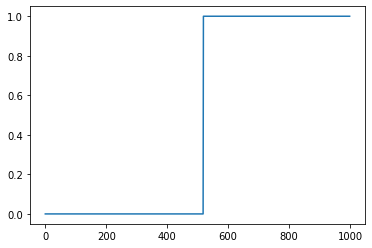

In [108]:
plt.plot(accuracies)
for layer in mlp_XOR.units:
  for unit in layer:
    print(unit.weights)